<a href="https://colab.research.google.com/github/Sciform/sciform-hwz-rl-and-qml/blob/main/quantum_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'qiskit>=1.0,<2.0'
!pip install qiskit[visualization] 'qiskit>=1.0,<2.0'
!pip install qiskit-machine-learning==0.8.2
!pip install nlopt
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=299bef613b611a0c2a4e09a7e722daffb6721e4fa46136e9b54dbefe3fcd93c1
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.8/436.8 kB 8.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

In [3]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

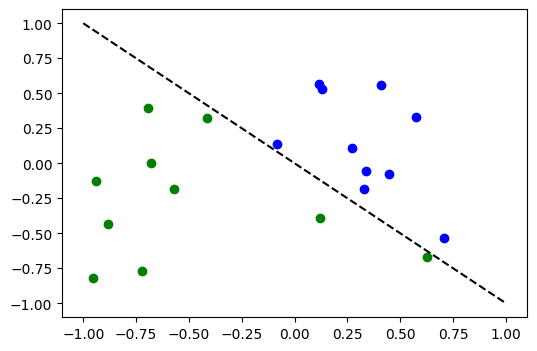

In [24]:
# create simple dataset

feature_dimensions = 2
num_samples = 20

X = 2 * algorithm_globals.random.random([num_samples, feature_dimensions]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))

for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()



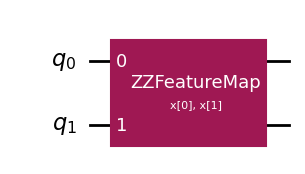

In [25]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(feature_dimensions)

feature_map.draw(output='mpl')

In [36]:
print(feature_map.decompose())

     ┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘


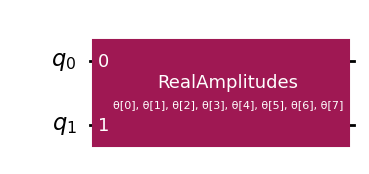

In [26]:
ansatz = RealAmplitudes(feature_dimensions, reps=1)
ansatz.draw(output='mpl')

In [27]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

In [29]:
# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
    sampler=sampler,
)

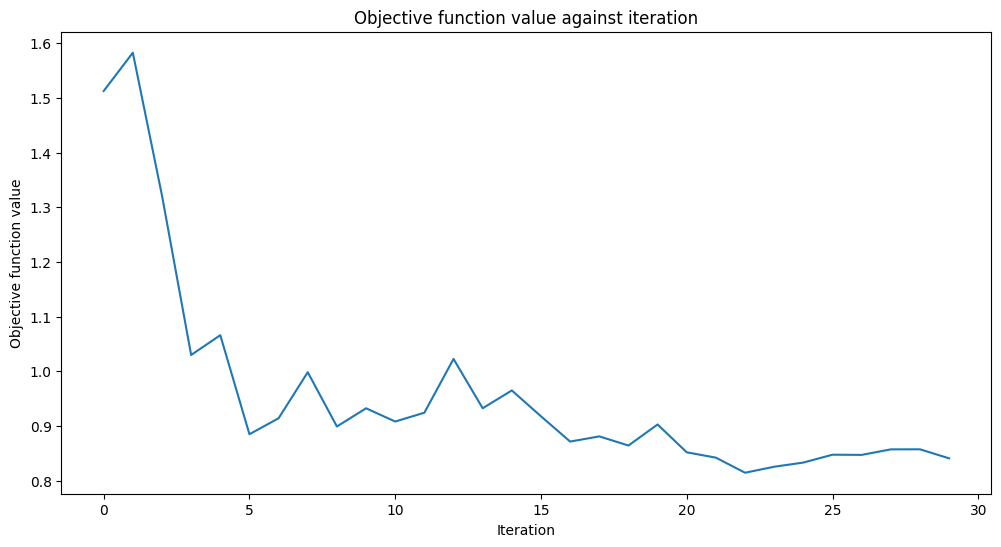

In [30]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# train classifier for the given data sewt
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [31]:
# score classifier
mean_accuracy = vqc.score(X, y_one_hot)
print(mean_accuracy)

0.65


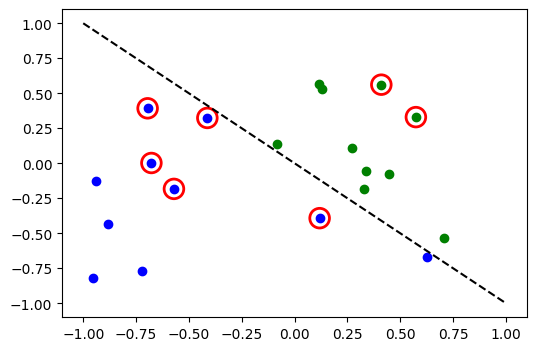

In [32]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

This code is a derivate of

© Copyright IBM 2017, 2024.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.
